In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
df = pd.read_csv("../data/data_files.csv", encoding= 'unicode_escape') # read the data

# Exploratory Data Analysis (EDA)

### Step 1: Let' s take a look at the data

In [3]:
df.sample(5)

,URL,Name
25933,https://raw.githubusercontent.com/elastic/elas...,JAVA
41487,https://raw.githubusercontent.com/nodejs/node/...,JAVASCRIPT
5457,https://raw.githubusercontent.com/django/djang...,PYTHON
44899,https://raw.githubusercontent.com/nodejs/node/...,JAVASCRIPT
7753,https://raw.githubusercontent.com/ansible/ansi...,PYTHON


### Step 2: Number of Unique Values in all the columns

In [4]:
df.nunique()

URL     75124
Name        8
dtype: int64

In [5]:
df.describe()

,URL,Name
count,75124,75124
unique,75124,8
top,https://raw.githubusercontent.com/gap-system/g...,JAVA
freq,1,26768


### Step 3: Unique Values in 'Name Column' (Going to be made the target variable)

In [6]:
df['Name'].unique()

array(['GAP', 'PYTHON', 'JAVA', 'JAVASCRIPT', 'TYPESCRIPT', 'GO', 'PHP',
       'RUBY'], dtype=object)

### Step 4: Duplicate Check for "URL" column (as this column should only have unique urls)

In [7]:
df['URL'].duplicated().sum()

0

### Step 5: Check the info() on the features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75124 entries, 0 to 75123
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URL     75124 non-null  object
 1   Name    75124 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


#### conclusion drawn from Step 5:
- both columns are of type 'object'

### Step 6: Check Class Distribution 

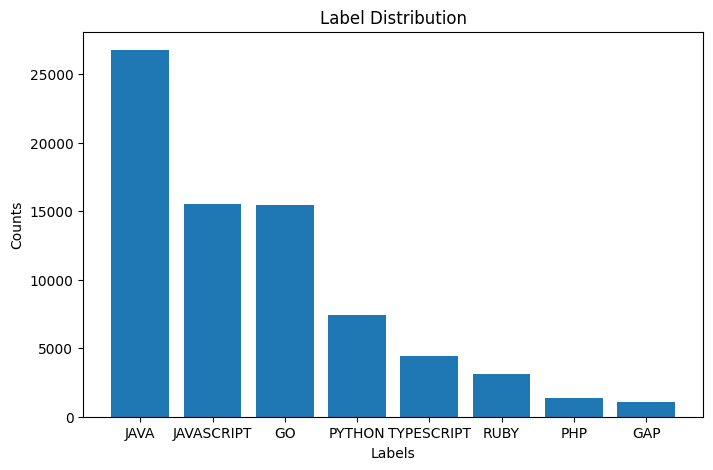

In [9]:
# Get the counts of unique labels within a column
label_counts = df['Name'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
# plt.xticks(rotation=90)
plt.title('Label Distribution')
plt.show()

# Custom Transformer classes (So that sklearn's pipeline can be used)

In [10]:
import re
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
import chardet # an ML model, It uses machine learning to detect the encoding of a file

# Custom transformer for case-folding
class CaseFoldingTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [x.lower() for x in X]

# Custom transformer for stop words removal
class StopWordsRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        stop_words_list = stopwords.words('english')
        return [' '.join([word for word in x.split() if word not in stop_words_list]) for x in X]
    
    # Custom transformer to remove numbers from text
class NumberRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Remove numbers using regular expression
        return [re.sub(r'\d+', '', text) for text in X]
    
class UrlToContentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for url in X:
            while True:
                try:    
                    response = requests.get(url)
                    content = response.content
                    encoding = chardet.detect(content)
        
                    if encoding['encoding'] == "ISO-8859-1":
                        transformed_X.append(content.decode("iso-8859-1"))
                    elif encoding['encoding'] == "GB2312":
                        transformed_X.append(content.decode("GB2312"))
                    else:
                        transformed_X.append(content.decode("utf-8"))
                    break
                except Exception as e:
                    print(url)
                    transformed_X.append(content.decode("utf-8"))
                    break
        return transformed_X

        
# Define the preprocessing steps
preprocessing_steps = [
#     ('case_folding', CaseFoldingTransformer()),
#     ('stop_words_removal', StopWordsRemovalTransformer()),
    ('url_to_content', UrlToContentTransformer()),
    ('number_removal', NumberRemovalTransformer()),
]

# Bag-of-Words (NLP technique)

In [11]:
# Bag-of-words can be implemented using "CountVectorizer" in sklearn
from sklearn.feature_extraction.text import CountVectorizer

# Make a preprocessing Pipeline

In [12]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessing', Pipeline(steps=preprocessing_steps)),
    ('vectorizer', CountVectorizer(max_features=3000))
])

#### Apply the preprocessing pipeline to the dataset

In [13]:
df['Content'] = pipeline['preprocessing'].fit_transform(df['URL'])

https://raw.githubusercontent.com/microsoft/vscode/main/src/vs/editor/test/common/model/linesTextBuffer/linesTextBufferBuilder.test.ts


#### Visualise the datset after the preprocessing pipeline

In [14]:
df['Content']

0        #description\n#author\n#timelimit\n#cmdlineops...
1        #description\n#author\n#timelimit\n#cmdlineops...
2        #description\n#author\n#timelimit\n#cmdlineops...
3        #description\n#author\n#timelimit\n#cmdlineops...
4        #description\n#author\n#timelimit\n#cmdlineops...
                               ...                        
75119    # frozen_string_literal: true\n\nrequire "abst...
75120    # frozen_string_literal: true\n\n# Order depen...
75121    # frozen_string_literal: true\n\n$: << File.ex...
75122    # frozen_string_literal: true\n\nif ENV["BUILD...
75123    # frozen_string_literal: true\n\nmodule Rails\...
Name: Content, Length: 75124, dtype: object

#### Save the content dataset to a CSV file

In [15]:
# Save the DataFrame to a CSV file
csv_file_path = '../data/content.csv'
df.to_csv(csv_file_path, index=False)

# Seperate the dataset into Independent and target variables

In [16]:
X = df['Content']
y = df['Name']

# Apply the Bag-of-Words

In [17]:
X_bow = pipeline['vectorizer'].fit_transform(X)

# Train-Test-Validation split

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training set (80%) and temporary set (20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

# Split the temporary set into validation set (10%) and final training set (90%)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=42)

#### check the length of the feature vectors

In [20]:
len( pipeline['vectorizer'].get_feature_names_out()) 

3000

#### Display the feature vectors

In [21]:
pipeline['vectorizer'].get_feature_names_out()

array(['__', '___', '__init__', ..., 'zoneddatetime', 'zoneid', 'zones'],
      dtype=object)

# Classifiers (Have more classifiers here and use RandomSearchCV for hyperparameter tuning)

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced') 

#### NOTE: class_weight='balanced' because as seen in evaluation GAP files are lower in comparison to the other programmming languages

# Cross-Validation

In [23]:
from sklearn.model_selection import cross_val_score

# Specify the number of folds
num_folds = 5

accuracy_scores = cross_val_score(clf, X_bow, y, cv=num_folds, scoring='accuracy')
print(np.mean(accuracy_scores))

0.9798461120000568


# Train the Model

In [24]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

# Evaluate the model

### Prection on test data

In [25]:
y_pred = clf.predict(X_test)

### Step 1: Accuracy

In [30]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9981364392678869


### Step 2: Precision

In [31]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred, average='weighted')
print(precision)

0.9981460297630381


### Step 3: Recall

In [32]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='weighted')
print(recall)

0.9981364392678869


### Step 4: F1-score

In [34]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

0.9981340341396896


### Step 5: Classfication Report (Summary of steps 1-4)

In [35]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         GAP       1.00      0.96      0.98       215
          GO       1.00      1.00      1.00      3021
        JAVA       1.00      1.00      1.00      5412
  JAVASCRIPT       1.00      1.00      1.00      3129
         PHP       1.00      1.00      1.00       271
      PYTHON       0.99      1.00      0.99      1451
        RUBY       1.00      1.00      1.00       596
  TYPESCRIPT       1.00      0.99      1.00       930

    accuracy                           1.00     15025
   macro avg       1.00      0.99      1.00     15025
weighted avg       1.00      1.00      1.00     15025



### Step 6: Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

#### Plot Confusion Matrix

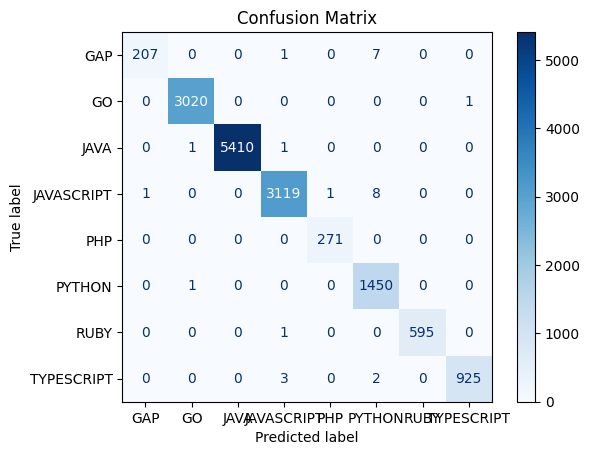

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='.0f')
plt.title('Confusion Matrix')
plt.show()

### Step 7: ROC-Curve (Can be used if the labels become:- "GAP" & "Others")

In [41]:
# from sklearn.metrics import roc_curve, roc_auc_score

# # Compute ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# auc = roc_auc_score(y_test, y_pred)

#### Plot ROC curve

In [42]:
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='b')
# plt.plot([0, 1], [0, 1], 'k--', color='gray', lw=2)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

# Save the model

In [43]:
import os

print(os.getcwd())
print(os.path.dirname(os.getcwd()))

C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks
C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub


In [57]:
import pickle

# Full pipeline with preprocessing and classifier
full_pipeline = Pipeline([
    ('full_preprocessing', pipeline),
    ('classifier', clf)
])

# Save the full_pipeline object
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
os.makedirs(clf_folder_path, exist_ok=True)
clf_file_path = os.path.join(clf_folder_path, 'classifier.pkl')

with open(clf_file_path, 'wb') as f:
    pickle.dump(full_pipeline, f)


# Load the saved model and see whether working or not

In [51]:
import joblib

# Load the saved pipeline
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
clf_file_path = os.path.join(clf_folder_path, 'classifier.pkl')
loaded_pipeline = joblib.load(clf_file_path)

# Use the loaded pipeline for predictions or other operations
predictions = loaded_pipeline.predict(['https://raw.githubusercontent.com/opencv/opencv/3aeaa3402389fc55e53fbc6f5741ca29f51032ee/modules/core/misc/java/src/java/core%2BMat.java'])

In [52]:
predictions

array(['JAVA'], dtype=object)